### Microalgae Bioreactor with Spray Column 

In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import pymc
import cronos 
import canon 
from magnus import ParEst

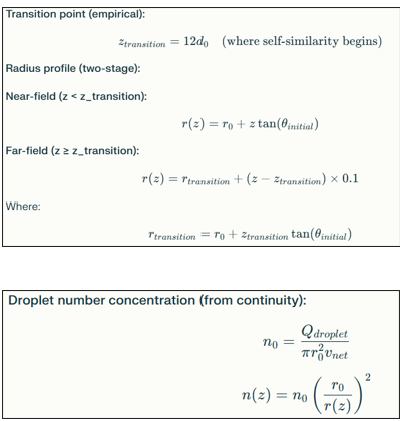

### Spray Development Block

In [2]:
#z transition 
def z_transition(d0):
    return 12 * d0
#z=0.1 #constant z for testing 
def radius_profile(z, d0, r0, theta_initial):
    zt = z_transition(d0)
    r_transition = r0 + zt * np.tan(theta_initial)

    if np.isscalar(z):
        z_val = z
        if z_val < zt:
            return r0 + z_val * np.tan(theta_initial)
        else:
            return r_transition + (z_val - zt) * 0.1
            
    z = np.array(z)
    r = np.zeros_like(z)

    # near-field
    mask_near = z < zt
    r[mask_near] = r0 + z[mask_near] * np.tan(theta_initial)

    # far-field
    mask_far = ~mask_near
    r[mask_far] = r_transition + (z[mask_far] - zt) * 0.1

    return r

### Hydrodynamics Block

In [3]:
import numpy as np

def droplet_hydrodynamics(
    d_drop,          # droplet diameter [m]
    rho_water=1000,  # density of water [kg/m³]
    rho_air=1.2,     # density of air [kg/m³]
    mu_gas=1.8e-5,   # gas viscosity [Pa s]
    Q_gas=0.5e1,      # gas volumetric flowrate [m³/s]  <-- separate from liquid!
    R_col=2.5,      # column radius [m]
    dz=1
):
    g = 9.81
    v_term = (2*g*(rho_water-rho_air)*d_drop**2) / (9*mu_gas)

    A_col = np.pi * R_col**2
    u_gas = Q_gas / A_col      # realistic gas superficial velocity

    v_net = v_term - u_gas
    t_res = dz / v_net

    return v_net, t_res

def droplet_number_concentration(Q_drop, R_col, v_net, d_drop):
    A_col = np.pi * R_col**2
    V_column_per_s = A_col * v_net      # m³/s of reactor

    # droplet volume fraction in that stream
    phi_vol = Q_drop / V_column_per_s   # dimensionless

    # volume of ONE droplet
    V_drop = (4/3)*np.pi*(d_drop/2)**3

    # number of droplets per m³ of reactor
    n0 = phi_vol / V_drop
    return n0

# Example usage
d_drop = 2e-4
Q_drop = 1e-3 # liquid volumetric flowrate
Q_gas  = 5e-4  # gas volumetric flowrate
R_col  = 2.5 #m
dz     = 1

v_net, t_res = droplet_hydrodynamics(d_drop, Q_gas=Q_gas, R_col=R_col, dz=dz)
n0 = droplet_number_concentration(Q_drop, R_col, v_net, d_drop)

print("v_net =", v_net)
print("t_res =", t_res)
print("n0 =", n0, "droplets/m³")


v_net = 4.838605646320215
t_res = 0.2066711100460326
n0 = 2512819.379344784 droplets/m³


### Light Distribution Model and Growth Model

In [4]:
IVPDAG = pymc.FFGraph()

#States 
X = pymc.FFVar(IVPDAG, "X") #biomass concentration
A = pymc.FFVar(IVPDAG, "A") #active photosynthesis  
B = pymc.FFVar(IVPDAG, "B") #occupied phoyosynthesis
C = pymc.FFVar(IVPDAG, "C") #damaged photosynthesis 
alpha = pymc.FFVar(IVPDAG, "alpha") #acclimation rate 
Ig = pymc.FFVar(IVPDAG, "G") #acclimation irradiance 
Xd = pymc.FFVar(IVPDAG, "Xd") #dormant biomass concentration

#Controls
v_net = pymc.FFVar(IVPDAG, "v_net") #net velocity 
I0 = pymc.FFVar(IVPDAG, "I0") #incident light intensity
D = pymc.FFVar(IVPDAG, "D") #dilution rate 
#Q_drop = pymc.FFVar(IVPDAG, "Q_gas") #droplet volumetric flowrate 

#initial concentrations 
X0 = pymc.FFVar(IVPDAG, "X0")
A0 = pymc.FFVar(IVPDAG, "A0")
B0 = pymc.FFVar(IVPDAG, "B0")
C0 = pymc.FFVar(IVPDAG, "C0")
alpha0 = pymc.FFVar(IVPDAG, "alpha0")
G0 = pymc.FFVar(IVPDAG, "G0")
Xd0 = pymc.FFVar(IVPDAG, "Xd0")

#parameters 
#nz = pymc.FFVar(IVPDAG, "nz") #droplet number concentration

#optical parameters
beta_par = pymc.FFVar(IVPDAG, "beta") #extinction coefficient 
sigma_par = pymc.FFVar(IVPDAG, "sigma") #scattering coefficient
#z = pymc.FFVar(IVPDAG, "z") #thickness of each layer

#kinetic parameters
kr = pymc.FFVar(IVPDAG, "kr") #repair rate
kd = pymc.FFVar(IVPDAG, "kd") #damage rate
Res = pymc.FFVar(IVPDAG, "R") #Respiration rate 
tau = pymc.FFVar(IVPDAG, "tau") #turnover rate
xi = pymc.FFVar(IVPDAG, "xi") #NPQ rate 
n_h = pymc.FFVar(IVPDAG, "n_h") #HII component 
eta_P = pymc.FFVar(IVPDAG, "eta_P") #photoproduction 
eta_D = pymc.FFVar(IVPDAG, "eta_D") #thermal decay 
eta_qE = pymc.FFVar(IVPDAG, "eta_qE") #qE-quenching 
eta_I = pymc.FFVar(IVPDAG, "eta_I") #qI-quenching
nu = pymc.FFVar(IVPDAG, "nu") #stochiometry 
rho = pymc.FFVar(IVPDAG, "rho") #acclimation rate 
k_chi = pymc.FFVar(IVPDAG, "k_chi") #chi component 
N_0 = pymc.FFVar(IVPDAG, "N_0") #reference RCII
I_qE0 = pymc.FFVar(IVPDAG, "I_qE0") #NPQ interceept 
base0 = pymc.FFVar(IVPDAG, "base0") # base σ
e = pymc.FFVar(IVPDAG, "e") #NPQ slope 
PS2 = pymc.FFVar(IVPDAG, "PS2") #effective cross-section of photosystem II
theta0 = pymc.FFVar(IVPDAG, "theta0") #chi quota 
delta = pymc.FFVar(IVPDAG, "delta") #acclimation rate parameter
lamb = pymc.FFVar(IVPDAG, "lambda") #constant 

#constant
R_col = 2.5 #radius of droplet column

### Mie Theory For Light Model

In [5]:
from scipy.special import spherical_jn, spherical_yn

def complex_refractive_index_droplet(theta_chl, X_gL, wavelength,
                                     a_chl_star,
                                     n_water=1.33,
                                     n_algae=1.39,
                                     rho_cell=1100.0): 
    """
    Computes complex refractive index of a water droplet containing microalgae.
    
    theta_chl : chlorophyll quota [g chl / g DW]
    X_gL      : biomass concentration in droplet [g DW / L]
    wavelength: wavelength [m]
    a_chl_star: chlorophyll-specific absorption [m^2/g chl]
    n_water   : refractive index of water
    n_algae   : refractive index of algal cytoplasm
    rho_cell  : cell density [kg/m^3]
    """

    # ---------- REAL PART (volume fraction mixing) ----------
    # Convert X from g/L → g/m3
    X_g_m3 = X_gL * 1000.0

    # Volume fraction of biomass in droplet
    f_vol = X_g_m3 / rho_cell
    f_vol = max(0.0, min(1.0, f_vol))  # clamp

    n_eff = f_vol * n_algae + (1 - f_vol) * n_water

    # ---------- IMAG PART (absorption from chlorophyll) ----------
    # Chlorophyll concentration in droplet [g/L → g/m3]
    C_chl_m3 = theta_chl * X_gL * 1000.0

    # absorption coefficient a(λ)
    a_lambda = a_chl_star * C_chl_m3   # [1/m]
    k_eff = a_lambda * wavelength / (4 * np.pi)
    n_new = n_eff + 1j * k_eff
    return n_new 

def mie_ab(m_rel, x, nmax):
    a = np.zeros(nmax, dtype=complex)
    b = np.zeros(nmax, dtype=complex)

    y = m_rel * x
    for n in range(1, nmax+1):
        jx   = spherical_jn(n, x)
        jx_p = spherical_jn(n, x, derivative=True)
        yx   = spherical_yn(n, x)
        yx_p = spherical_yn(n, x, derivative=True)
        hx   = jx + 1j*yx
        hx_p = jx_p + 1j*yx_p

        jy   = spherical_jn(n, y)
        jy_p = spherical_jn(n, y, derivative=True)

        a[n-1] = (m_rel*jy*jx_p - jx*jy_p) / (m_rel*jy*hx_p - hx*jy_p)
        b[n-1] = (jy*jx_p - m_rel*jx*jy_p) / (jy*hx_p - m_rel*hx*jy_p)

    return a, b

def mie_Qext(m_rel, r, wavelength):
    x = 2*np.pi*r / wavelength
    nmax = int(np.round(x + 4*x**(1/3) + 2))
    a, b = mie_ab(m_rel, x, nmax)
    n = np.arange(1, nmax+1)
    Q_ext = (2/x**2) * np.sum((2*n+1)*np.real(a + b))
    Q_sca = (2/x**2) * np.sum((2*n+1)*(np.abs(a)**2 + np.abs(b)**2))
    return Q_ext, Q_sca

def mie_coeff(d, wavelength, m_rel, n0):
    r = d/2
    Q_ext, Q_sca = mie_Qext(m_rel, r, wavelength)
    C_ext = Q_ext * np.pi * r**2
    C_sca = Q_sca * np.pi * r**2
    beta_mie = n0 * C_ext
    sigma_mie = n0 * C_sca
    return beta_mie, sigma_mie

#Guess initial parameter values
if __name__ == "__main__":
    d_drop = 2e-4
    n0 = 2513070.6710706623
    wavelength = 550e-9
    theta_chi = 3.60
    X_gL = 3.0 
    a_chl_star = 20
    n_new = complex_refractive_index_droplet(theta_chi, X_gL, wavelength, a_chl_star)
    m_rel = n_new / 1.33
    beta_mie, sigma_mie = mie_coeff(d_drop, wavelength, m_rel, n0)
    print("Complex refractive index:", n_new)
    print("m_rel", m_rel)
    print("Extinction coefficient beta:", beta_mie)
    print("Scattering coefficient sigma:", sigma_mie)


Complex refractive index: (1.39+0.009453803619658583j)
m_rel (1.045112781954887+0.0071081230222996864j)
Extinction coefficient beta: 0.15929491726773187
Scattering coefficient sigma: 0.08050660698988449


In [6]:
IVP = cronos.ODESLV()
IVP.set_dag(IVPDAG)
IVP.set_parameter([beta_par, sigma_par, base0, kr, kd, Res, tau, xi, n_h, nu, eta_P, eta_D, eta_qE, eta_I, k_chi, e, PS2, rho, N_0, I_qE0, theta0, delta, lamb])
IVP.set_constant([I0, D, X0, A0, B0, C0, alpha0, G0, Xd0])
IVP.set_state([X, A, B, C, alpha, Ig, Xd])

time_grid = np.linspace(0, 0.1, 52).tolist() # 2 hours 
IVP.set_time(time_grid)
print(time_grid)

# light model 
b = 0.15 
f = 1 - b
X_tot    = X + Xd
beta_par = beta_mie * X_tot
sigma_par = sigma_mie * X_tot
sqrt3 = np.sqrt(3.0)
K = 200 #number of spatial steps
#dx = R_col / K #discretize the droplet column height
z_grid = np.linspace(0, R_col, K)
dz = z_grid[1] - z_grid[0]

#Boundary conditions
F_plus = I0 
F_minus = 0.0 

for k in range(K):
    dF_plus = sqrt3 * (-beta_par*F_plus + sigma_par * (f*F_plus + b*F_minus))
    dF_minus = sqrt3 * ( beta_par*F_minus - sigma_par * (f*F_minus + b*F_plus))
    F_plus   = F_plus  + dF_plus  * dz
    F_minus  = F_minus + dF_minus * dz
    I = F_plus - F_minus

# growth model 
theta  = theta0 * Ig**k_chi
N      = N_0 * Ig**lamb
I_qE    = I_qE0 + e * Ig
mum_raw= (I * base0 * nu * 
            (A * eta_P) /
            (1 + eta_D + eta_qE*alpha + A*eta_P + C*eta_I)
            - Res) * theta

eps_mu  = 1e-12
mum_max = 5.0e-5    # [s^-1]  ≈ 0.18 h^-1
mum = mum_raw / (1.0 + ((mum_raw * mum_raw + eps_mu)**0.5) / mum_max) #bounded mum 

dIg = delta * (I - Ig) * mum
sigma_PS2 = base0 * eta_P / (N * (1 + eta_D + eta_qE*alpha + eta_P))
k_AB = I * sigma_PS2 * A                    # A → B (closure by light)
k_BA = B / tau                                  # B → A (reopening / relaxation)
k_BC = kd * I * sigma_PS2 * B              # B → C (photodamage)
k_CB = kr * C                                   # C → B (repair)

# 2. Conservative ODEs 
dA = -k_AB + k_BA 
dB =  k_AB - k_BA - k_BC + k_CB
dC =  k_BC - k_CB

Phi_f_A = 1.0 / (1 + eta_P + eta_D + eta_qE*alpha)
Phi_f_B = 1.0 / (1 + eta_D + eta_qE*alpha)
Phi_f_C = 1.0 / (1 + eta_I + eta_D + eta_qE*alpha)
NPQ_target = (I**n_h) / (I_qE**n_h + I**n_h)
dalpha =  -xi * (alpha - NPQ_target)

#biomass 
dX = (mum - D) * X   
dXd = Res * X - D * Xd       

IVP.set_differential([dX, dA, dB, dC, dalpha, dIg, dXd])    
IVP.set_initial([X0, A0, B0, C0, alpha0, G0, Xd0])
Y = [I, X, A, B, C, alpha, Ig, mum]
nY = len(Y)

# use function indices 0..nY-1 for every time point
F = [{j: Y[j] for j in range(nY)} for _ in time_grid]

IVP.set_function(F)
IVP.setup()
print(IVP.eqn_function)

[0.0, 0.00196078431372549, 0.00392156862745098, 0.0058823529411764705, 0.00784313725490196, 0.00980392156862745, 0.011764705882352941, 0.013725490196078431, 0.01568627450980392, 0.01764705882352941, 0.0196078431372549, 0.021568627450980392, 0.023529411764705882, 0.025490196078431372, 0.027450980392156862, 0.029411764705882353, 0.03137254901960784, 0.03333333333333333, 0.03529411764705882, 0.03725490196078431, 0.0392156862745098, 0.041176470588235294, 0.043137254901960784, 0.045098039215686274, 0.047058823529411764, 0.049019607843137254, 0.050980392156862744, 0.052941176470588235, 0.054901960784313725, 0.056862745098039215, 0.058823529411764705, 0.060784313725490195, 0.06274509803921569, 0.06470588235294117, 0.06666666666666667, 0.06862745098039216, 0.07058823529411765, 0.07254901960784313, 0.07450980392156863, 0.07647058823529412, 0.0784313725490196, 0.08039215686274509, 0.08235294117647059, 0.08431372549019608, 0.08627450980392157, 0.08823529411764705, 0.09019607843137255, 0.092156862

In [7]:
IVP.options.DISPLEVEL = 1     # display numerical integration results
IVP.options.RESRECORD = 50    # record 50 points along time horizon

param_vals = [
    # --- optical (3) ---
    beta_mie,      # 1  beta_par
    sigma_mie,     # 2  sigma_par
    1.75,          # 3  base0

    # --- kinetic rates (7) ---
    5.50e-5,       # 4  kr
    6.41e-7,       # 5  kd
    1.78e-5,       # 6  Res
    5e-3,       # 7  tau
    5.95e-2,       # 8  xi
    2.26,          # 9  n_h
    4.0,           # 10 nu

    # --- photochemistry / quenching (6) ---
    1.14e1,        # 11 eta_P
    5.0e0,         # 12 eta_D
    1.98e1,        # 13 eta_qE
    7.87e1,        # 14 eta_I
    -1.89e-1,      # 15 k_chi
    4.48e-1,       # 16 e

    # --- acclimation / photoacclimation (6) ---
    1.38e-1,       # 17 rho
    1.71,          # 18 N_0
    8.13e2,        # 19 I_qE0
    3.60,          # 20 theta0
    1.38e-1,       # 21 delta
    1.22e-1        # 22 lamb
]

const_vals = [
    50,    # I0
    1.0e-7,   # D
    0.1,  # X0
    0.50,   # A0
    0.30,   # B0
    0.20,   # C0   (acclimation irradiance initial)
    0.0,   # alpha0   (incident light)
    100,    #G0   (dilution rate)
       0   # Xd0
]

# Run the IVP
IVP.solve_state(param_vals, const_vals)


 @t = 0.000000e+00 :
  x[0] = 1.000000e-01
  x[1] = 5.000000e-01
  x[2] = 3.000000e-01
  x[3] = 2.000000e-01
  x[4] = 0.000000e+00
  x[5] = 1.000000e+02
  x[6] = 0.000000e+00
 @t = 1.960784e-03 :
  x[0] = 1.000000e-01
  x[1] = 5.972592e-01
  x[2] = 2.027408e-01
  x[3] = 2.000000e-01
  x[4] = 5.822552e-05
  x[5] = 1.000000e+02
  x[6] = 3.490196e-09
 @t = 3.921569e-03 :
  x[0] = 1.000000e-01
  x[1] = 6.629586e-01
  x[2] = 1.370414e-01
  x[3] = 2.000000e-01
  x[4] = 1.164443e-04
  x[5] = 1.000000e+02
  x[6] = 6.980393e-09
 @t = 5.882353e-03 :
  x[0] = 1.000000e-01
  x[1] = 7.073391e-01
  x[2] = 9.266100e-02
  x[3] = 1.999999e-01
  x[4] = 1.746562e-04
  x[5] = 1.000000e+02
  x[6] = 1.047059e-08
 @t = 7.843137e-03 :
  x[0] = 1.000000e-01
  x[1] = 7.373184e-01
  x[2] = 6.268166e-02
  x[3] = 1.999999e-01
  x[4] = 2.328613e-04
  x[5] = 1.000000e+02
  x[6] = 1.396079e-08
 @t = 9.803922e-03 :
  x[0] = 1.000000e-01
  x[1] = 7.575697e-01
  x[2] = 4.243037e-02
  x[3] = 1.999999e-01
  x[4] = 2.91059

<Status.Normal: 0>

  x[5] = 1.000000e+02
  x[6] = 1.745098e-08
 @t = 1.176471e-02 :
  x[0] = 1.000001e-01
  x[1] = 7.712497e-01
  x[2] = 2.875046e-02
  x[3] = 1.999999e-01
  x[4] = 3.492513e-04
  x[5] = 1.000000e+02
  x[6] = 2.094118e-08
 @t = 1.372549e-02 :
  x[0] = 1.000001e-01
  x[1] = 7.804906e-01
  x[2] = 1.950957e-02
  x[3] = 1.999998e-01
  x[4] = 4.074360e-04
  x[5] = 1.000000e+02
  x[6] = 2.443138e-08
 @t = 1.568627e-02 :
  x[0] = 1.000001e-01
  x[1] = 7.867329e-01
  x[2] = 1.326727e-02
  x[3] = 1.999998e-01
  x[4] = 4.656140e-04
  x[5] = 1.000000e+02
  x[6] = 2.792158e-08
 @t = 1.764706e-02 :
  x[0] = 1.000001e-01
  x[1] = 7.909497e-01
  x[2] = 9.050537e-03
  x[3] = 1.999998e-01
  x[4] = 5.237852e-04
  x[5] = 9.999999e+01
  x[6] = 3.141178e-08
 @t = 1.960784e-02 :
  x[0] = 1.000001e-01
  x[1] = 7.937981e-01
  x[2] = 6.202097e-03
  x[3] = 1.999998e-01
  x[4] = 5.819496e-04
  x[5] = 9.999999e+01
  x[6] = 3.490198e-08
 @t = 2.156863e-02 :
  x[0] = 1.000001e-01
  x[1] = 7.957223e-01
  x[2] = 4.27794

In [8]:
#simulated results
Pred_Exp = []
for rec in IVP.results_state: 
    Pred_Exp.append([rec.t] + rec.x) 
Pred_Exp = np.array(Pred_Exp) 

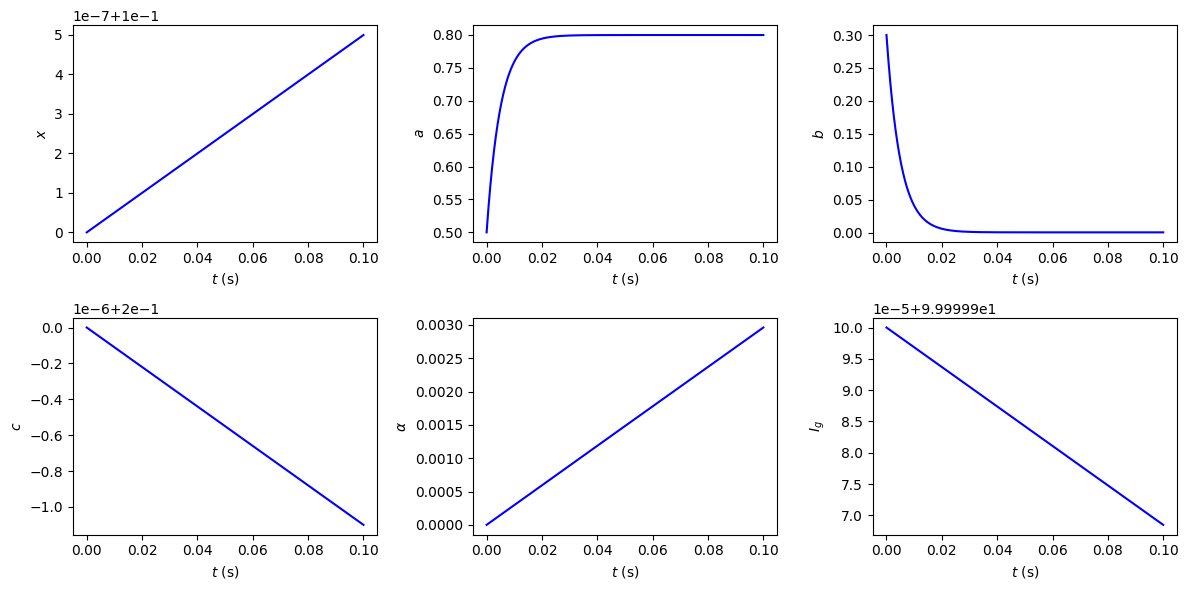

In [9]:
fig, axes = plt.subplots(2, 3, figsize=(12, 6))

# --- x ---
axes[0,0].plot(Pred_Exp[:,0], Pred_Exp[:,1], color="blue")
axes[0,0].set(xlabel="$t$ (s)")
axes[0,0].set(ylabel="$x$")

# --- a ---
axes[0,1].plot(Pred_Exp[:,0], Pred_Exp[:,2], color="blue")
axes[0,1].set(xlabel="$t$ (s)")
axes[0,1].set(ylabel="$a$")

# --- b ---
axes[0,2].plot(Pred_Exp[:,0], Pred_Exp[:,3], color="blue")
axes[0,2].set(xlabel="$t$ (s)")
axes[0,2].set(ylabel="$b$")

# --- c ---
axes[1,0].plot(Pred_Exp[:,0], Pred_Exp[:,4], color="blue")
axes[1,0].set(xlabel="$t$ (s)")
axes[1,0].set(ylabel="$c$")

# --- alpha ---
axes[1,1].plot(Pred_Exp[:,0], Pred_Exp[:,5], color="blue")
axes[1,1].set(xlabel="$t$ (s)")
axes[1,1].set(ylabel=r"$\alpha$")

# --- Ig ---
axes[1,2].plot(Pred_Exp[:,0], Pred_Exp[:,6], color="blue")
axes[1,2].set(xlabel="$t$ (s)")
axes[1,2].set(ylabel="$I_g$")

# Remove empty axes (there should be none)
[fig.delaxes(ax) for ax in axes.flatten() if not ax.has_data()]
fig.tight_layout()
plt.show()
